In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
plt.rcParams['font.sans-serif'] = ['SimHei']        # 设置中文字体为黑体
plt.rcParams['axes.unicode_minus'] = False 

# 📌 读取数据
df = pd.read_csv("C:/Users/Administrator/Desktop/traffic_speed_data.csv")

In [2]:
le_type = LabelEncoder()
df['车型编码'] = le_type.fit_transform(df['车型'])

le_time = LabelEncoder()
df['时间段编码'] = le_time.fit_transform(df['时间段'])

# ✅ 2. 准备聚类特征（速度 + 编码列）
X = df[['速度', '车型编码', '时间段编码']]

# ✅ 3. 标准化数据
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [8]:
from sklearn.cluster import KMeans

# 使用 3 类聚类
kmeans = KMeans(n_clusters=3, random_state=42)
df['cluster'] = kmeans.fit_predict(X_scaled)


In [9]:
# 计算 IQR 范围
Q1 = df['速度'].quantile(0.25)
Q3 = df['速度'].quantile(0.75)
IQR = Q3 - Q1

# 设定边界
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 标记异常点
df['is_outlier'] = (df['速度'] < lower_bound) | (df['速度'] > upper_bound)


In [10]:
from sklearn.decomposition import PCA

# PCA 降到二维以便可视化
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# 加入到原数据中
df['PCA1'] = X_pca[:, 0]
df['PCA2'] = X_pca[:, 1]


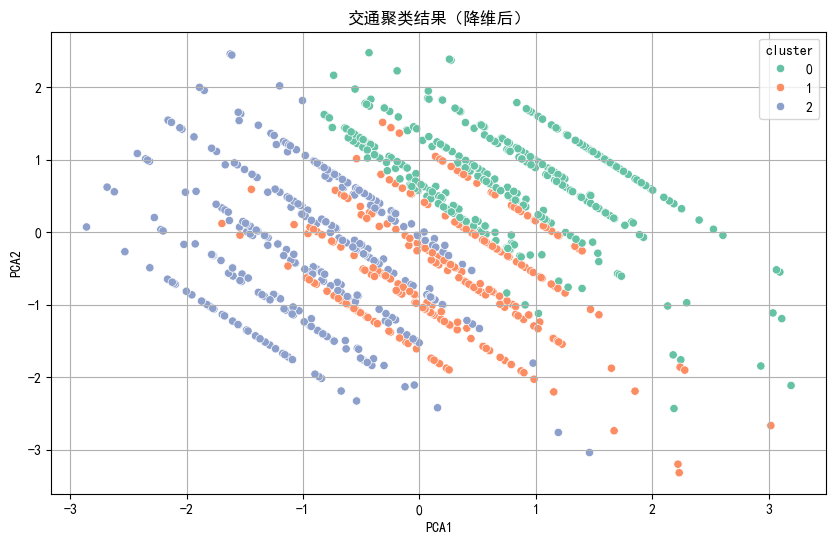

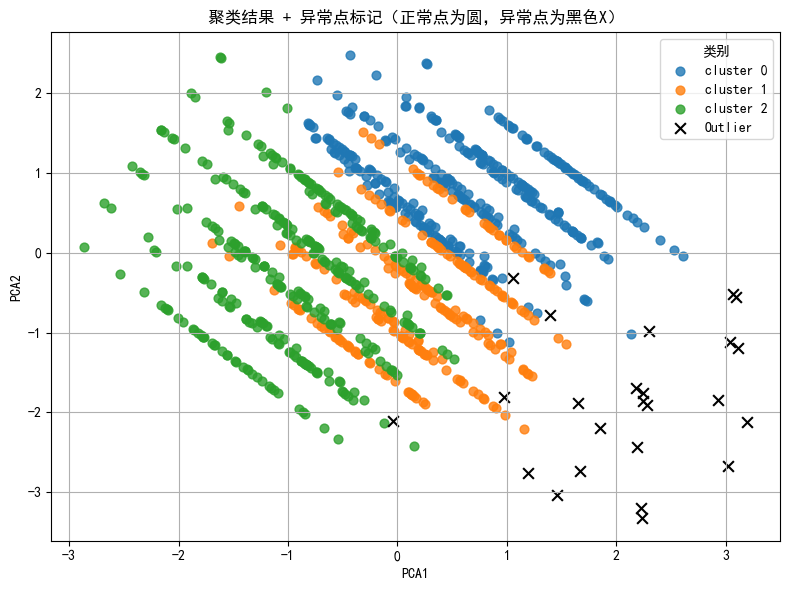

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# 聚类结果的散点图
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='PCA1', y='PCA2', hue='cluster', palette='Set2')
plt.title("交通聚类结果（降维后）")
plt.grid(True)
plt.show()

import matplotlib.pyplot as plt

# 确保 df 中包含以下列：
# df['PCA1'], df['PCA2'], df['cluster'], df['is_outlier']（布尔值）

plt.figure(figsize=(8, 6))

# 1. 正常点（不同 cluster，不同颜色，用圆点）
for cluster_label in sorted(df['cluster'].unique()):
    cluster_data = df[(df['cluster'] == cluster_label) & (~df['is_outlier'])]
    plt.scatter(
        cluster_data['PCA1'], cluster_data['PCA2'],
        label=f'cluster {cluster_label}', s=40, alpha=0.8
    )

# 2. 异常点：统一用黑色 X
outliers = df[df['is_outlier']]
plt.scatter(
    outliers['PCA1'], outliers['PCA2'],
    color='black', marker='x', s=60, label='Outlier'
)

# 图形优化
plt.title("聚类结果 + 异常点标记（正常点为圆，异常点为黑色X）")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.legend(title="类别")
plt.grid(True)
plt.tight_layout()
plt.show()



In [28]:
# 聚类编号 + 车型分布
vehicle_distribution = df.groupby(['cluster', '车型']).size().unstack().fillna(0)
vehicle_distribution = vehicle_distribution.apply(lambda x: x / x.sum(), axis=1)  # 转为比例
print("🚗 各聚类中的车型占比：")
print(vehicle_distribution)


🚗 各聚类中的车型占比：
车型            公交车        卡车       小汽车       自行车
cluster                                        
0        0.085399  0.209366  0.399449  0.305785
1        0.000000  0.000000  0.400709  0.599291
2        0.566197  0.433803  0.000000  0.000000


In [26]:
# 聚类编号 + 时间段分布
time_distribution = df.groupby(['cluster', '时间段']).size().unstack().fillna(0)
time_distribution = time_distribution.apply(lambda x: x / x.sum(), axis=1)
print("🕐 各聚类中的时间段占比：")
print(time_distribution)


🕐 各聚类中的时间段占比：
时间段            上午        下午        中午        夜间       早高峰       晚高峰
cluster                                                            
0        0.000000  0.000000  0.002755  0.162534  0.358127  0.476584
1        0.312057  0.244681  0.322695  0.120567  0.000000  0.000000
2        0.225352  0.180282  0.230986  0.216901  0.135211  0.011268


In [16]:
# 聚类编号 + 速度统计
speed_stats = df.groupby('cluster')['速度'].describe()
print("🚀 各聚类的速度统计：")
print(speed_stats)


🚀 各聚类的速度统计：
         count       mean        std  min        25%        50%        75%  \
cluster                                                                      
0        363.0  43.927085  18.185588  0.0  32.249563  42.125754  52.830158   
1        282.0  40.008333  18.363362  0.0  29.608238  39.579265  50.326448   
2        355.0  40.301112  18.072585  0.0  29.959268  40.363292  50.810010   

                max  
cluster              
0        113.365784  
1        117.170296  
2        112.670277  


In [23]:
def plot_vehicle_distribution(df):
    """绘制每个聚类内的车型分布柱状图"""
    import seaborn as sns
    import matplotlib.pyplot as plt

    vehicle_counts = df.groupby(['cluster', '车型']).size().reset_index(name='数量')
    plt.figure(figsize=(10, 5))
    sns.barplot(data=vehicle_counts, x='cluster', y='数量', hue='车型')
    plt.title("🚗 各聚类中的车型分布")
    plt.xlabel("聚类编号")
    plt.ylabel("数量")
    plt.legend(title="车型")
    plt.tight_layout()
    plt.show()
def plot_time_distribution(df):
    """绘制每个聚类内的时间段分布柱状图"""
    import seaborn as sns
    import matplotlib.pyplot as plt

    time_counts = df.groupby(['cluster', '时间段']).size().reset_index(name='数量')
    plt.figure(figsize=(10, 5))
    sns.barplot(data=time_counts, x='cluster', y='数量', hue='时间段')
    plt.title("🕐 各聚类中的时间段分布")
    plt.xlabel("聚类编号")
    plt.ylabel("数量")
    plt.legend(title="时间段")
    plt.tight_layout()
    plt.show()
def plot_speed_boxplot(df):
    """绘制每个聚类中的速度分布箱型图"""
    import seaborn as sns
    import matplotlib.pyplot as plt

    plt.figure(figsize=(10, 5))
    sns.boxplot(data=df, x='cluster', y='速度', palette='Set2')
    plt.title("🚀 各聚类的速度分布（箱型图）")
    plt.xlabel("聚类编号")
    plt.ylabel("速度（km/h）")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


C:\Users\Administrator\AppData\Local\Temp\ipykernel_6592\3099317883.py:13: UserWarning: Glyph 128663 (\N{AUTOMOBILE}) missing from font(s) SimHei.
  plt.tight_layout()
C:\Users\Administrator\.conda\envs\ssdasdasd00000\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128663 (\N{AUTOMOBILE}) missing from font(s) SimHei.
  fig.canvas.print_figure(bytes_io, **kw)


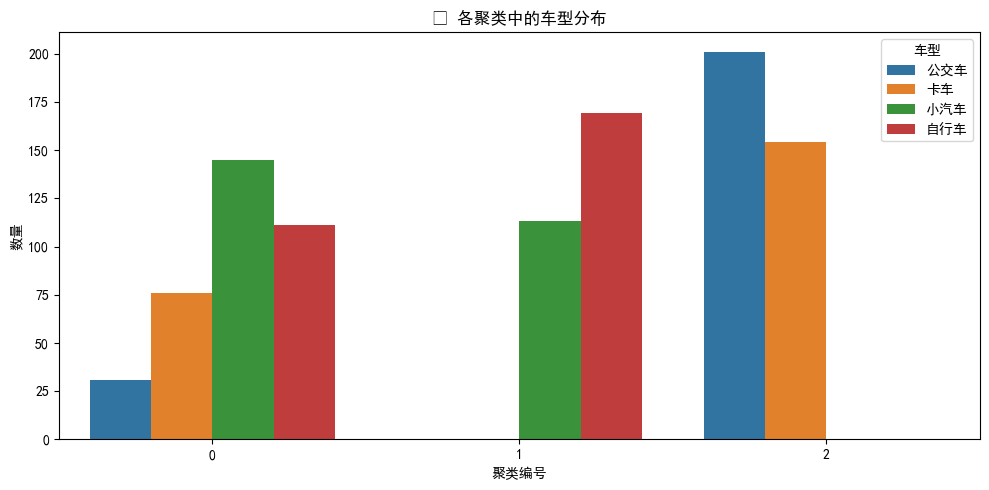

C:\Users\Administrator\AppData\Local\Temp\ipykernel_6592\3099317883.py:27: UserWarning: Glyph 128336 (\N{CLOCK FACE ONE OCLOCK}) missing from font(s) SimHei.
  plt.tight_layout()
C:\Users\Administrator\.conda\envs\ssdasdasd00000\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128336 (\N{CLOCK FACE ONE OCLOCK}) missing from font(s) SimHei.
  fig.canvas.print_figure(bytes_io, **kw)


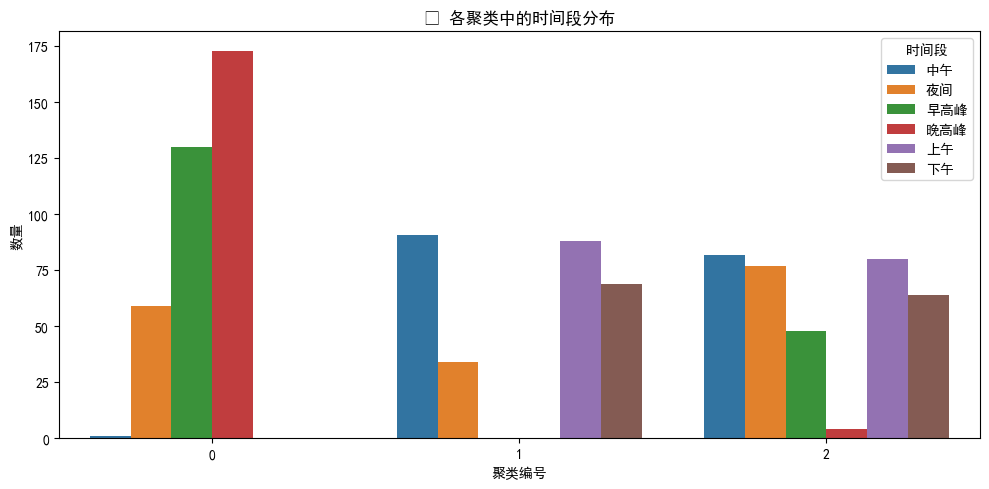

C:\Users\Administrator\AppData\Local\Temp\ipykernel_6592\3099317883.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='cluster', y='速度', palette='Set2')
C:\Users\Administrator\AppData\Local\Temp\ipykernel_6592\3099317883.py:40: UserWarning: Glyph 128640 (\N{ROCKET}) missing from font(s) SimHei.
  plt.tight_layout()
C:\Users\Administrator\.conda\envs\ssdasdasd00000\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128640 (\N{ROCKET}) missing from font(s) SimHei.
  fig.canvas.print_figure(bytes_io, **kw)


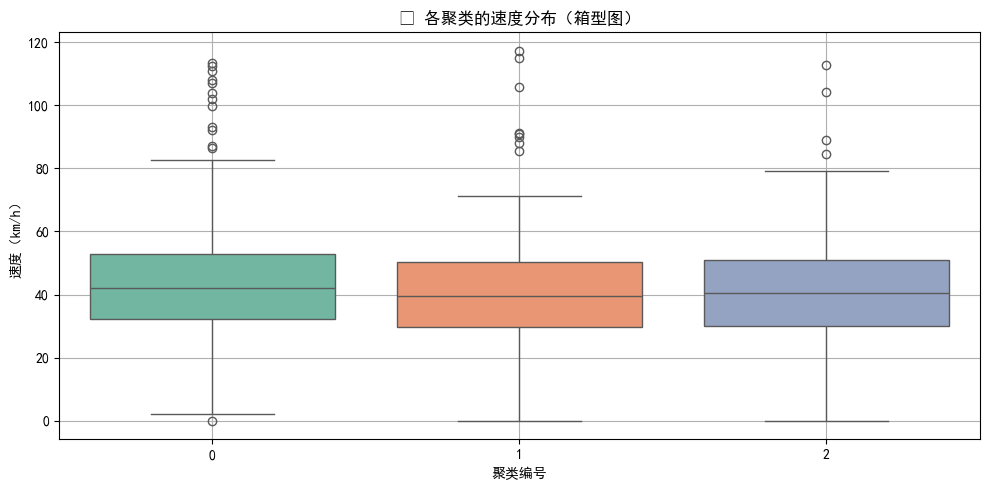

In [24]:
plot_vehicle_distribution(df)
plot_time_distribution(df)
plot_speed_boxplot(df)
